In [71]:
import pandas as pd
import xml.etree.ElementTree as et
import json
import zipfile
import matplotlib.pyplot as plt
import itertools

#### Dataset - Wine Reviews
130k wine reviews with variety, location, winery, price, and description

https://www.kaggle.com/zynicide/wine-reviews

| column | description|
| --- | --- |
| country | The country that the wine is from
| description | ---
| designation | The vineyard within the winery where the grapes that made the wine are from
| points | The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for
| price | The cost for a bottle of the wine
| province | The cost for a bottle of the wine
| region_1 | The wine growing area in a province or state (ie Napa)
| region_2 | Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley)
| taster_name | ---
| taster_twitter_handle | ---
| title | The title of the wine review, which often contains the vintage
| variety | The type of grapes used to make the wine (ie Pinot Noir)
| winery | The winery that made the wine


#### Configure Kaggle API

In [72]:
pip install kaggle

In [73]:
!mkdir C:\Users\Krutizna\.kaggle 
!touch 'C:\Users\Krutizna\.kaggle\kaggle.json'

In order to use the Kaggle’s public API, you must first authenticate using an API token. 
To get your own follow instructions: https://www.kaggle.com/docs/api#getting-started-installation-&-authentication 

In [74]:
api_token = {"username":"pacificus","key":""}

with open(r'C:\Users\Krutizna\.kaggle\kaggle.json', 'w') as file:
    json.dump(api_token, file)

#### Download dataset and unzip it

In [75]:
!C:\Users\Krutizna\Anaconda3\Scripts\kaggle datasets download -d zynicide/wine-reviews

In [76]:
with zipfile.ZipFile('wine-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [77]:
base_file = 'winemag-data-130k-v2.csv'
base_file = '/kaggle/input/wine-reviews/winemag-data-130k-v2.csv'

In [78]:
df = pd.read_csv(base_file, index_col=0)
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


#### Look at the data

Count and drop non unique rows

In [79]:
print("Total rows: ", df.shape[0])
print("Not unique rows: ", df[df.duplicated(['description','title'])].shape[0])
df = df[~df.duplicated(['description','title'])]
print("Count after dropping: ", df.shape[0])

Total rows:  129971
Not unique rows:  9983
Count after dropping:  119988


Count nan values

In [80]:
df.isnull().sum(axis=0)

country                     59
description                  0
designation              34545
points                       0
price                     8395
province                    59
region_1                 19560
region_2                 73219
taster_name              24917
taster_twitter_handle    29446
title                        0
variety                      1
winery                       0
dtype: int64

Impute nan values

In [81]:
df.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [82]:
df_object = df.select_dtypes(include='object').fillna('Unknown') 
df_numeric = df.select_dtypes(include=['int64', 'float64']) 

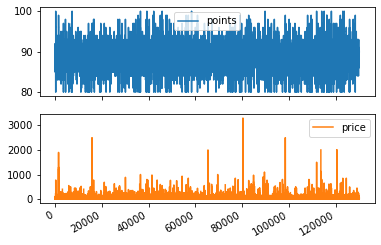

In [83]:
df_numeric.plot(subplots=True)
plt.show()

In [84]:
df_numeric = df_numeric.fillna(df_numeric.median()) 

In [85]:
df =  pd.concat([df_object, df_numeric], axis=1, sort=False)
df.shape

(119988, 13)

#### Create simple version  to_xml()

Set string type to all column for success serialization

In [86]:
df = df.astype('str')
df.dtypes

country                  object
description              object
designation              object
province                 object
region_1                 object
region_2                 object
taster_name              object
taster_twitter_handle    object
title                    object
variety                  object
winery                   object
points                   object
price                    object
dtype: object

In [87]:
def to_xml(df, filename='text.xml'):
    
    root = et.Element('data');

    for i,row in df.iterrows():
        item = et.SubElement(root, 'item', attrib=row.to_dict());

    tree = et.ElementTree(root)
    tree.write(filename)
    
pd.DataFrame.to_xml = to_xml

In [88]:
df.iloc[0:500].to_xml()

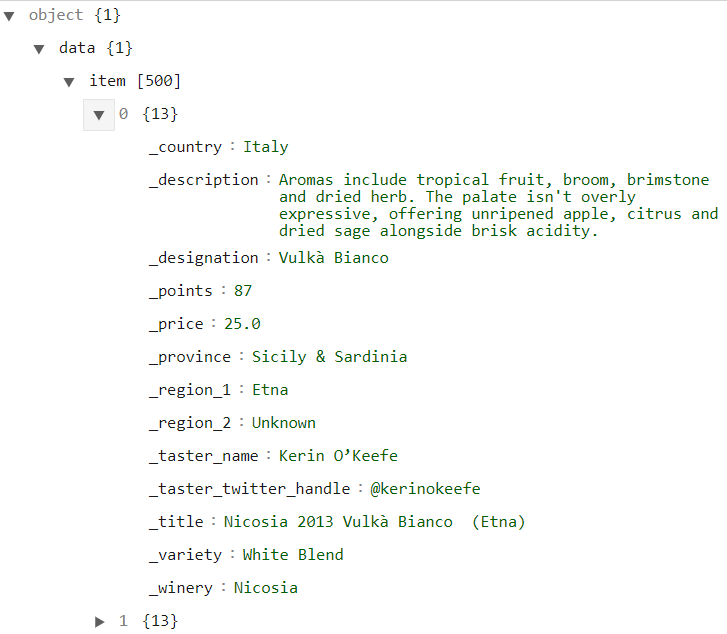

#### Create full version of to_xml() to create a file with functional dependencies

In [89]:
df.head()

,country,description,designation,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,points,price
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,Sicily & Sardinia,Etna,Unknown,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,87,25.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,Douro,Unknown,Unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,87,15.0
2,US,"Tart and snappy, the flavors of lime flesh and...",Unknown,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,87,14.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,Michigan,Lake Michigan Shore,Unknown,Alexander Peartree,Unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,87,13.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,87,65.0


**Definition 1.** The relation R satisfies the FD X → Y (where X, Y ⊆ R) if and only if for any tuples t1, t2 ∈ R: if t1[X] = t2[X], then t1[Y] = t2[Y]. In such a case, X (the determinant, or defining attribute) is said to use the property Y (dependent set).

In [94]:
def is_dependency(col1, col2):
    temp = {}
    n = len(col1)
    for i in range(n):
        if col1.iloc[i] in temp:
            if temp[col1.iloc[i]] != col2.iloc[i]:
                return False
        else:
            temp[col1.iloc[i]] = col2.iloc[i]
    return True

In [95]:
%%time
for cols in itertools.combinations(df.columns, 2):
    if is_dependency(df[cols[0]], df[cols[1]]):
        print(f'{cols[0]} -> {cols[1]}')
    if is_dependency(df[cols[1]], df[cols[0]]):
        print(f'{cols[1]} -> {cols[0]}')

province -> country
title -> country
title -> designation
title -> province
title -> region_1
title -> region_2
taster_name -> taster_twitter_handle
title -> winery
CPU times: user 46.8 s, sys: 16.7 ms, total: 46.8 s
Wall time: 46.8 s


In [92]:
def to_full_xml(df, filename='fulltext.xml'):
    wine_info_cols = ['title', 'description', 'designation', 'region_1', 'region_2', 'winery', 'price']
    tester_info_cols = ['taster_name', 'taster_twitter_handle']
    province_info_cols = ['country', 'province']
    wine_review_cols = ['points', 'variety']
    
    root = et.Element('data');

    for i,row in df.iterrows():
        wine_review = et.SubElement(root, 'wine_review', attrib=row[wine_review_cols].to_dict())
        wine_info = et.SubElement(wine_review, 'wine_info', attrib=row[wine_info_cols].to_dict())
        province_info = et.SubElement(wine_info, 'province_info', attrib=row[province_info_cols].to_dict())
        tester_info = et.SubElement(wine_review, 'tester_info', attrib=row[tester_info_cols].to_dict())

    tree = et.ElementTree(root)
    tree.write(filename)
    
pd.DataFrame.to_full_xml = to_full_xml

In [93]:
df[:500].to_full_xml()

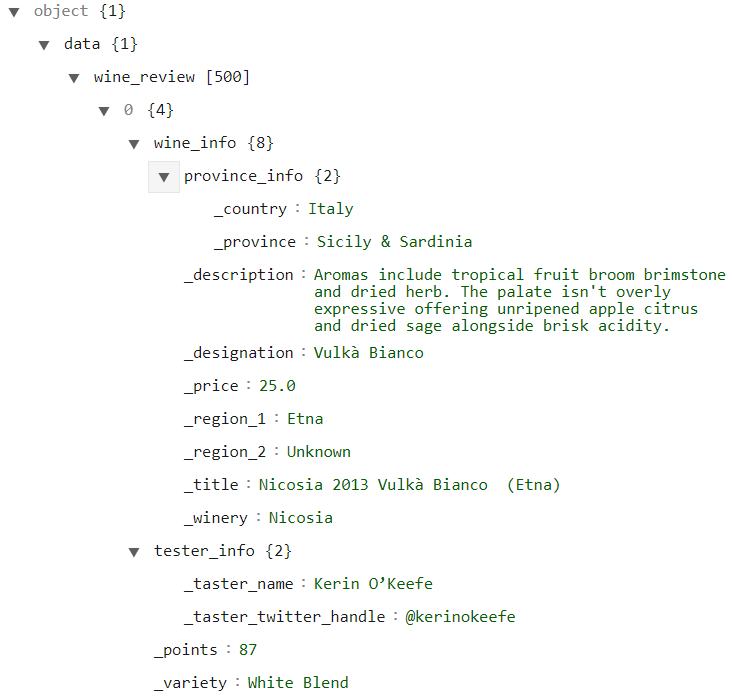